In [1]:
import pandas as pd

from dirty_cat.datasets import fetch_traffic_violations
road_safety = fetch_traffic_violations()
print(road_safety.description)

/Users/leo/PycharmProjects/dirty_cat/dirty_cat/datasets/fetching.py:554: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  return fetch_dataset_as_namedtuple(


This dataset contains traffic violation information from all electronic traffic violations issued in the County. Any information that can be used to uniquely identify the vehicle, the vehicle owner or the officer issuing the violation will not be published.


In [2]:
import numpy as np
data = road_safety.X[["date_of_stop", "time_of_stop", "longitude", "latitude", "gender", "alcohol", "subagency"]].dropna()
y = road_safety.X["accident"]
X = road_safety.X.drop("accident", axis=1)
# Reduce dataset size for speed
rng = np.random.default_rng(1)
indices = rng.choice(range(len(y)), 5000)
X, y = X.iloc[indices], y.iloc[indices]

In [3]:
from sklearn.preprocessing import OneHotEncoder
from dirty_cat.datetime_encoder import DatetimeEncoder
cat_encoder = OneHotEncoder(handle_unknown="ignore")
datetime_encoder = DatetimeEncoder(add_day_of_the_week=True)

In [4]:
from sklearn.compose import make_column_transformer
datetime_columns = ["date_of_stop", "time_of_stop"]
numerical_columns = ["longitude", "latitude"]
categorical_columns = ["gender", "alcohol", "subagency"]

X = X[datetime_columns + numerical_columns + categorical_columns].dropna()

encoder = make_column_transformer((cat_encoder, categorical_columns),
                                  (datetime_encoder, datetime_columns),
                                  ("passthrough", numerical_columns),
                                  remainder="drop")

In [5]:
# Inspecting features created
from sklearn.ensemble import HistGradientBoostingClassifier

X_ = encoder.fit_transform(X)
clf = HistGradientBoostingClassifier().fit(X_, y)
feature_names = encoder.get_feature_names_out()

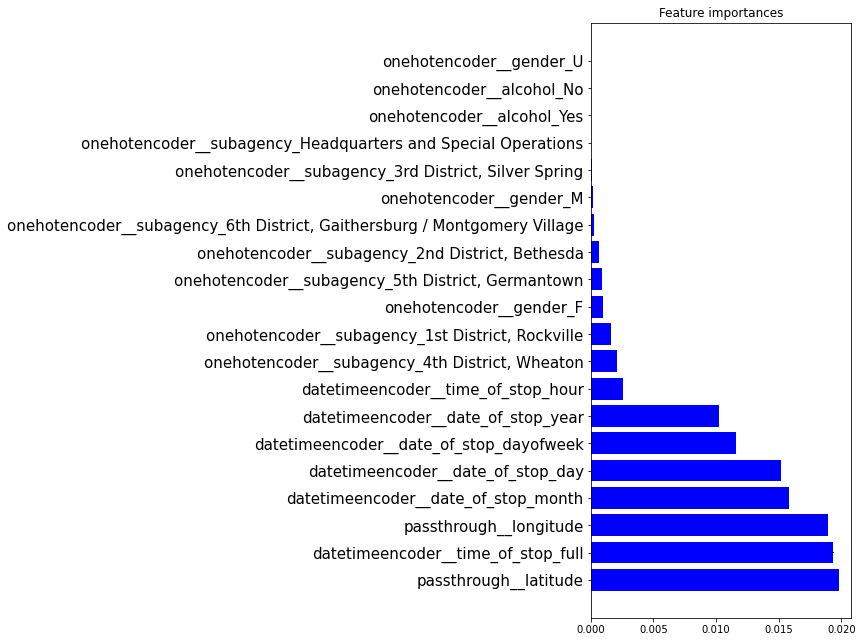

In [6]:
from sklearn.inspection import permutation_importance
result = permutation_importance(clf, X_, y, n_repeats=2, random_state=0)
std = result.importances_std
importances = result.importances_mean
indices = np.argsort(importances)
# Sort from least to most
indices = list(reversed(indices))
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
plt.title("Feature importances")
n = len(indices)
labels = np.array(feature_names)[indices]
plt.barh(range(n), importances[indices], color="b", yerr=std[indices])
plt.yticks(range(n), labels, size=15)
plt.tight_layout(pad=1)
plt.show()

In [7]:
# Oneliner with the SuperVectorizer
from dirty_cat import SuperVectorizer
sup_enc = SuperVectorizer()
X_ = sup_enc.fit_transform(X)
clf = HistGradientBoostingClassifier().fit(X_, y)
feature_names = sup_enc.get_feature_names_out()

/Users/leo/opt/anaconda3/envs/dirty_cat/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [8]:
sup_enc.transformers_

[('low_card_cat', OneHotEncoder(), ['gender', 'alcohol', 'subagency']),
 ('high_card_cat',
  GapEncoder(n_components=30),
  ['date_of_stop', 'time_of_stop']),
 ('remainder', 'passthrough', [2, 3])]

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(clf, X_, y, n_repeats=2, random_state=0)
std = result.importances_std
importances = result.importances_mean
indices = np.argsort(importances)
# Sort from least to most
indices = list(reversed(indices))
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
plt.title("Feature importances")
n = len(indices)
labels = np.array(feature_names)[indices]
plt.barh(range(n), importances[indices], color="b", yerr=std[indices])
plt.yticks(range(n), labels, size=15)
plt.tight_layout(pad=1)
plt.show()

In [ ]:
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(encoder, clf)
pipeline

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipeline, X, y)

pipeline.fit(X, y)
feature_names = pipeline["supervectorizer"].get_feature_names_out()
result = permutation_importance(pipeline_sup_enc, X, y, n_repeats=2, random_state=0)
std = result.importances_std
importances = result.importances_mean
print(importances.shape)
indices = np.argsort(importances)
# Sort from least to most
indices = list(reversed(indices))
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
plt.title("Feature importances")
n = 20
n_indices = indices[:n]
labels = np.array(feature_names)[n_indices]
plt.barh(range(n), importances[n_indices], color="b", yerr=std[n_indices])
plt.yticks(range(n), labels, size=15)
plt.tight_layout(pad=1)
plt.show()



In [110]:
datetime_columns = ["date_of_stop", "time_of_stop"]
numerical_columns = ["longitude", "latitude"] + datetime_columns
categorical_columns = ["gender", "alcohol", "subagency"]
X["date_of_stop"] = pd.to_datetime(X["date_of_stop"]).astype(int)
X["time_of_stop"] = pd.to_datetime(X["time_of_stop"]).astype(int)

/var/folders/fy/__8z8cpn6gs04465sq9g1nq80000gn/T/ipykernel_32423/3034180366.py:4: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  X["date_of_stop"] = pd.to_datetime(X["date_of_stop"]).astype(int)
/var/folders/fy/__8z8cpn6gs04465sq9g1nq80000gn/T/ipykernel_32423/3034180366.py:5: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  X["time_of_stop"] = pd.to_datetime(X["time_of_stop"]).astype(int)


In [111]:
encoder = make_column_transformer((cat_encoder, categorical_columns),
                                  ("passthrough", numerical_columns),
                                  remainder="drop")

In [112]:
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(encoder, clf)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'alcohol',
                                                   'subagency']),
                                                 ('passthrough', 'passthrough',
                                                  ['longitude', 'latitude',
                                                   'date_of_stop',
                                                   'time_of_stop'])])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier())])

In [114]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipeline, X, y)
#pipeline.fit(X, y)

array([0.9749, 0.9748, 0.9749, 0.9749, 0.9751])

In [107]:
X["date_of_stop"]

746764             NaN
807733      -8640000.0
1191770    -51926400.0
1499978    -53740800.0
55002      216950400.0
              ...     
124241     151977600.0
183360      -9072000.0
80193       15120000.0
910770    -121219200.0
568254      47779200.0
Name: date_of_stop, Length: 50000, dtype: float64

In [124]:
data

,date_of_stop,time_of_stop,longitude,latitude,gender,alcohol,subagency
0,09/11/2019,09:56:00,-77.223760,39.259627,F,No,"2nd District, Bethesda"
1,09/11/2019,09:42:00,-77.162435,39.112860,M,No,"1st District, Rockville"
2,09/11/2019,09:36:00,-77.068113,39.117080,M,No,"1st District, Rockville"
3,09/11/2019,09:33:00,-77.105873,38.991630,F,No,"2nd District, Bethesda"
4,09/11/2019,09:30:00,-77.073673,39.064560,F,No,"4th District, Wheaton"
...,...,...,...,...,...,...,...
1578149,01/01/2012,00:52:00,0.000000,0.000000,F,No,"3rd District, Silver Spring"
1578150,01/01/2012,00:52:00,0.000000,0.000000,F,No,"3rd District, Silver Spring"
1578151,01/01/2012,00:52:00,0.000000,0.000000,F,No,"3rd District, Silver Spring"
1578152,01/01/2012,00:52:00,0.000000,0.000000,F,No,"3rd District, Silver Spring"
